In [1]:
import numpy as np
import scipy.io
import scipy.linalg
from scipy.linalg import fractional_matrix_power as matpow
from ssid import okid
from control.matlab import * #need for "ss"
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from matplotlib import pyplot as plt


In [2]:
# Load data
p = 2   # Number of outputs
q = 2   # Number of inputs
n = 100 # State dimension (Number of structural dofs x 2)
r = 10  # Reduced model order ()
dt = 1  # Timestep
bruntondata = scipy.io.loadmat("./brunton_matlab/brunton_data.mat")
yImpulseFull = bruntondata['yFull']
yImpulse = bruntondata['YY']
uRandom = bruntondata['uRandom']
yRandom = bruntondata['yRandom']
print(yImpulse.shape)

(2, 2, 52)


In [3]:
def _svd(*args):
    U,S,V = scipy.linalg.svd(*args, lapack_driver="gesvd")
    return U,S,V.T.conj()

In [4]:
def okid(output,input,r):
    pass
# okid.okid(yRandom,uRandom,dt=1,kmax=200,orm=52,mro=100)

Dimensions
- p = Number of outputs (measured dof or ndof)
- q = Number of inputs (ngdof)
- n = State dimension (2ndof)
- r = Reduced model order (choose)

Full model
- Dimensions of $\mathbf{A}$: n x n
- Dimensions of $\mathbf{B}$: n x q
- Dimensions of $\mathbf{C}$: p x n
- Dimensions of $\mathbf{D}$: p x q

Reduced model
- Dimensions of $\mathbf{\tilde{A}}$: r x r
- Dimensions of $\mathbf{\tilde{B}}$: r x q
- Dimensions of $\mathbf{\tilde{C}}$: p x r
- Dimensions of $\mathbf{\tilde{D}}$: p x q

In [5]:
# example state evolution with unit impulse input

from sympy.matrices import Matrix, eye
B = Matrix(np.array([['a','b','c'],['d','e','f'],['g','h','i']]))
u1 = Matrix([1,0,0])
u2 = Matrix([0,1,0])
u3 = Matrix([0,0,1])
U = eye(3)

Bu1 = Matrix(B*u1).T
Bu2 = Matrix(B*u2).T
Bu3 = Matrix(B*u3).T

display("B = ", B)
display("U = ", U)
display("u1 = ", u1)
display("u2 = ", u2)
display("u3 = ", u3)
display("[Bu1, Bu2, Bu3] = ", Bu1.T.row_join(Bu2.T.row_join(Bu3.T)))
display("BU = ", B*U)

print("this illustrates that the desired impulse response (Y) is the matrix",
      "where each column corresponds to the column vector of output response (yi)",
      "corresponding to an input column vector where the ith element is one",
      "and all others are zero (ui).")

'B = '

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

'U = '

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

'u1 = '

Matrix([
[1],
[0],
[0]])

'u2 = '

Matrix([
[0],
[1],
[0]])

'u3 = '

Matrix([
[0],
[0],
[1]])

'[Bu1, Bu2, Bu3] = '

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

'BU = '

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

this illustrates that the desired impulse response (Y) is the matrix where each column corresponds to the column vector of output response (yi) corresponding to an input column vector where the ith element is one and all others are zero (ui).


In [36]:
# Y = output data: response to unit impulse, or "impulse response," or "markov parameters".
    # dimensions of Y: p x q x nt, where nt = number of timesteps = number of markov parameters = number of blocks
# mc = number of block rows in Hankel matrix
# mo = number of block columns in Hankel matrix
# p = number of outputs
# q = number of inputs
# r = reduced model order = dimension of reduced A = newly assumed dimension of state variable

def era(Y,mo,mc,p,q,r,dt=1):
    # get D from first input_dimension columns of impulse response
    Dr = Y[:,:,0]  # first block of output data
    
    assert Y.shape[:2] == (p,q)  # sanity check that we're passing in the right output data
    assert Y.shape[2] >= mo+mc   # make sure there are enough timesteps to assemble this size of Hankel matrix
    
    # make impulse response into hankel matrix and shifted hankel matrix
    H0 = np.zeros((p*mo, q*mc))
    H1 = np.zeros((p*mo, q*mc))
    for i in range(mo):
        for j in range(mc):
            H0[p*i:p*(i+1), q*j:q*(j+1)] = Y[:,:,i+j+1]
            H1[p*i:p*(i+1), q*j:q*(j+1)] = Y[:,:,i+j+2]
    # reduced svd of hankel matrix
    U,S,V = _svd(H0)
    Sigma = np.diag(S[:r])
    Ur = U[:,:r]
    Vr = V[:,:r]

    # get A from svd and shifted hankel matrix
    Ar = matpow(Sigma,-0.5) @ Ur.T @ H1 @ Vr @ matpow(Sigma,-0.5)

    # get B and C
    Br = (matpow(Sigma,0.5) @ Vr.T)[:,:q]
    Cr = (Ur @ matpow(Sigma,0.5))[:p,:]

    # eigendecomp A
    W,R = scipy.linalg.eig(Ar)

    # get frequencies from eigendecomp of A
    omega = np.log(W + 2*np.pi*1j/dt)
    print(f"{omega=}")

    # get modeshapes from C and eigendecomp of A
    phi = Cr @ R
    print(f"{phi=}")    

    # return (Ar,Br,Cr,Dr,omega,phi)
    return (Ar,Br,Cr,Dr,S)

In [37]:
## Compute ERA from impulse response
mco = int(np.floor((yImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = era(yImpulse,mco,mco,q,p,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)

omega=array([5.01354615+0.00572201j, 5.01354615-0.00572201j,
       5.00948449+0.j        , 5.01230465+0.00080531j,
       5.01230465-0.00080531j, 5.02176418+0.00181127j,
       5.02176418-0.00181127j, 5.02028422+0.j        ,
       5.02245271+0.j        , 5.02219124+0.j        ])
phi=array([[-0.78799378-1.02287479j, -0.78799378+1.02287479j,
         0.31239591+0.j        ,  2.13463838-0.10717162j,
         2.13463838+0.10717162j, -1.41984137+0.64580042j,
        -1.41984137-0.64580042j,  0.52160609+0.j        ,
         0.37292667+0.j        ,  0.61445464+0.j        ],
       [ 1.08380386+0.01695736j,  1.08380386-0.01695736j,
         0.98607247+0.j        , -0.17421541-0.916869j  ,
        -0.17421541+0.916869j  ,  0.33333002-0.13752255j,
         0.33333002+0.13752255j,  1.95125281+0.j        ,
        -0.60567734+0.j        , -0.52844194+0.j        ]])


In [38]:
## Load impulse response data from hayward opensees
# exp = "changecol"
exp = "changedof"

input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
input21  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u1.txt")
output11 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output21 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")

input12  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u2.txt")
input22  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u2.txt")
output12 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output22 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")
nt = len(input11)
dt = 0.1


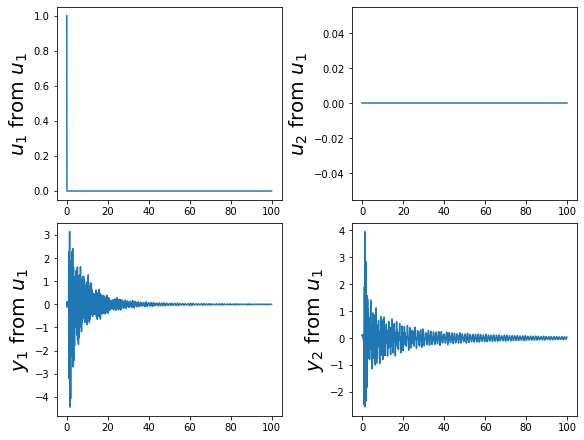

In [39]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input11)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input21)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{1}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output11)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output21)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20);

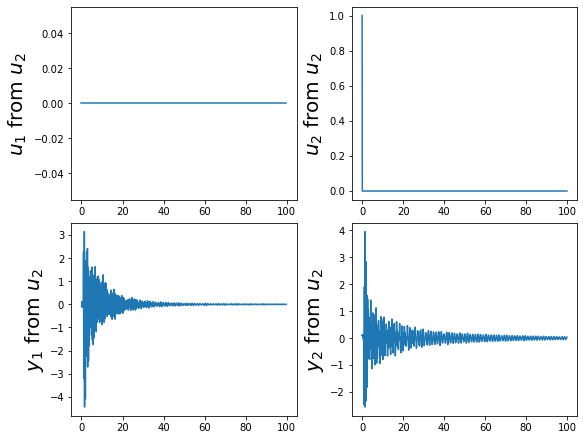

In [40]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input12)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{2}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input22)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{2}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output12)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output22)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20);

In [41]:
# Construct output data array
yOpsImpulse = np.array([[output11,output21],[output12,output22]])
yOpsImpulse.shape
print(yOpsImpulse[:,:,:5])

[[[-0.101611  -0.0504431  0.123423   0.0925321 -0.0963987]
  [ 0.111061   0.127751   0.056576   0.047713   0.123795 ]]

 [[-0.101611  -0.0504431  0.123423   0.0925321 -0.0963987]
  [ 0.111061   0.127751   0.056576   0.047713   0.123795 ]]]


In [42]:
## Compute ERA from impulse response
mco = int(np.floor((yOpsImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = era(yOpsImpulse,mco,mco,q,p,20)
sysERA = ss(Ar,Br,Cr,Dr,dt)

omega=array([8.04875824+1.50520861e-04j, 8.04875824-1.50520861e-04j,
       8.04872197+2.03638422e-04j, 8.04872197-2.03638422e-04j,
       8.04873436+1.87222922e-04j, 8.04873436-1.87222922e-04j,
       8.04854265+2.97725795e-04j, 8.04854265-2.97725795e-04j,
       8.04845355+3.15662811e-04j, 8.04845355-3.15662811e-04j,
       8.04840757+2.93880044e-04j, 8.04840757-2.93880044e-04j,
       8.0484295 +3.14676230e-04j, 8.0484295 -3.14676230e-04j,
       8.04818462+9.44856257e-05j, 8.04818462-9.44856257e-05j,
       8.04816942+5.59518034e-05j, 8.04816942-5.59518034e-05j,
       8.04817633+2.36772359e-05j, 8.04817633-2.36772359e-05j])
phi=array([[-0.34919621+0.23010014j, -0.34919621-0.23010014j,
        -0.03121062-0.18364209j, -0.03121062+0.18364209j,
         0.02440634-0.14234496j,  0.02440634+0.14234496j,
        -0.05095518-0.51832755j, -0.05095518+0.51832755j,
         0.73701958-0.53575303j,  0.73701958+0.53575303j,
        -0.59381706-0.60436559j, -0.59381706+0.60436559j,
        -0.

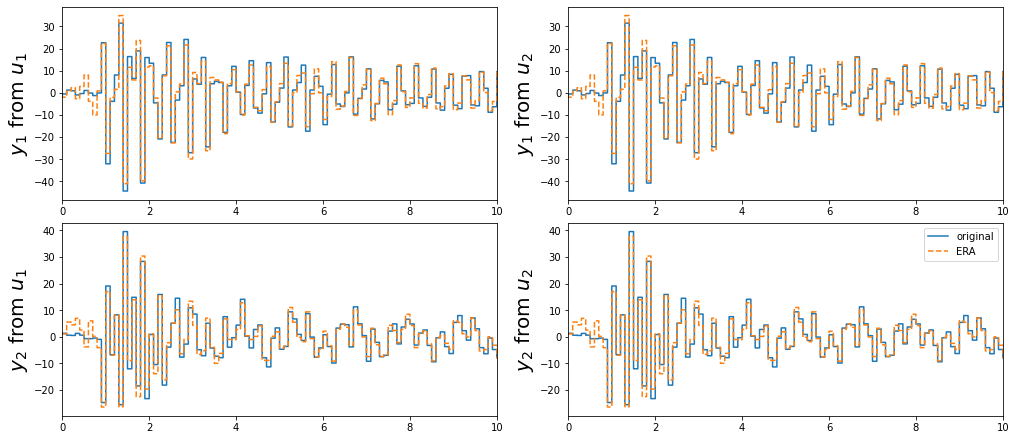

In [35]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERA = np.zeros((1000,p,q))
for i in range(q):
    yERA[:,:,i],times = impulse(sysERA,np.arange(start=0,stop=100,step=dt),input=i)

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,1,0], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,0,1], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label='ERA')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20)
ax[1,1].legend()
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10);